# GaWC Rankings Visualization
## By Tim Lupien

The Globalization and World Cities Research Network (GaWC) is an organization which, being aptly named, conducts many interesting research projects on the interconnectedness of world cities. Every couple of years they put out a sort of tier list of global cities, ranked by how important they are to the global network based on many factors, but primarily on their importance to multinational corporations.

I find this list interesting and wanted to visualize it on a map. Unfortunately, the GaWC has only put out their most recent (2020) version of this list in the form of a screenshot, which can be found here: https://www.lboro.ac.uk/microsites/geography/gawc/world2020t.html

I was not deterred. In this project, I start with only this image

![image](./data/GaWC/2020_world_cities_ranking.jpg)

and create a dataset of ranked cities with coordinates via OCR and web scraping. I then take it another step further for the sake of visualization, clustering the cities with DBSCAN, making the clusters into landmasses divided up by voronoi diagrams of their respective cities. The unclustered cities become islands via a similar process.

All of these shapes are created as polygons and multipolygons under ESPG 4326 and remain associated with their respective city. The end result is not just my visualization, but a geodataframe of cities with the columns city_id, name, latitude, longitude, ranking, labels (the cluster id), and this newly created geometry, which can be exported to a shapefile.

If actually running this code, I recommend skipping the blocks for web-scraping and manual review, as I have provided csv files containing the results of those two time-intesnive steps already.

In [ ]:
import numpy as np
import pandas as pd
import pytesseract
import re
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import geometry
from scipy.spatial import Voronoi
from sklearn.cluster import DBSCAN
import alphashape
from collections import defaultdict
from shapely.geometry import Polygon
import requests
import bs4
import time

## Creating the initial dataset

### OCR
The first step here was to get the names out of the image. I could have manually transcribed them all, but that would have taken a long time. Instead I thought, since the image is pretty much just (annoyingly un-copy-able) text, optical character recognition could get good results, and I was right.

First, I lightly preprocessed the image by thresholding it in gimp. The result is the file `cities_bw_2.png` in this folder.

I used tesseract (via pytesseract) for this process:

In [2]:
ocr_results = pytesseract.image_to_string('./data/GaWC/cities_bw_2.png')

I've omitted the (~400 line long) ouput here, but it had some obvious messiness that needed to be taken out before the list of names was useable:

In [3]:
# get rid of multiple linebreaks in a row
single_lb = re.compile(r'\n{2,}')
ocr_results = single_lb.sub('\n',ocr_results)

# get rid of labels
labels = re.compile(r'Alpha|Beta|Gamma|Sufficiency')
ocr_results = labels.sub('',ocr_results)

# get rid of punctuation, anything in parentheses, and anything after
# a forward slash
punctuation = re.compile(r'[+\-,.]|[\(\{][a-zA-Z ]+[\)\}]|/[a-zA-Z ]+')
ocr_results = punctuation.sub('',ocr_results)

# make it into a list and strip surrounding white spaces
city_list = ocr_results.split('\n')
for i in range(len(city_list)):
    city_list[i] = city_list[i].strip()

empty_spaces = re.compile(r'^\s+$')

# eliminate any list items that are just empty space
i = 0
while True:
    try:
        if city_list[i] == ''\
        or empty_spaces.match(city_list[i]) != None:
            del city_list[i]
        else:
            i += 1
    except IndexError:
        break

### Getting Coordinates
Getting coordinates with just city names is not as straightforward as it may seem. I found a couple of datasets for this, but since the exact spellings didn't always match, there wasn't a good way to distinguish between cities with the same name in different countries, and the datasets were often just incomplete in odd ways, I decided on a web scraping approach instead.

Fortunately, wikipedia has a wide variety of useful redirects set up. For example, even though the actual address for the wikipedia page of Ulaanbaatar (the capitol of Mongolia) is `https://en.wikipedia.org/wiki/Ulaanbaatar`, the url `https://en.wikipedia.org/wiki/Ulan Bator` with an actual non-url-formatted space, gets you to the correct page. This wonderful behavior made grabbing the latitude and longitude from there a viable option, and I do so below.

I was, however, unsure of how much they would appreciate ~400 pages being opened at once from my IP, so I crippled the program by adding a one second delay between each. This is probably overkill, but I figured it was better safe than sorry and I used the time to make eggs.

In [ ]:
# maybe skip this cell

# these lists will have same order as city_list and be used to make df
latitude = []
longitude = []
bad_indices = []

for i in range(len(city_list)):
    # look up the city name on wikipedia
    res = requests.get(f'https://en.wikipedia.org/wiki/{city_list[i]}')
    soup = bs4.BeautifulSoup(res.text,'html.parser')
    
    # if found, grab coordinates
    try:
        lat = soup.find(class_ = "latitude").text
        long = soup.find(class_ = "longitude").text
        latitude.append(lat)
        longitude.append(long)
        
    # if not, make a note of it and add nulls
    except AttributeError:
        bad_indices.append(i)
        latitude.append(np.NaN)
        longitude.append(np.NaN)
    
    # respect the wikipedia project.
    time.sleep(1)

city_df = pd.DataFrame(data=zip(city_list,latitude,longitude),
                       columns=['city_name','latitude','longitude'])

# saved this as a csv, so I wouldn't have to run the long web scraping
# more than once
city_df.to_csv('./dataGaWC/cities.csv', index=False)

In [4]:
# load the result of the above cell
city_df = pd.read_csv('./data/GaWCcities.csv')

In [5]:
print(
f'{round(city_df.latitude.isnull().sum() / city_df.shape[0] * 100, 2)}%\
 were unsuccessful.')

12.4% were unsuccessful.


By doing this OCR + web-scraping, **I reduced the manual review needed by a factor of 8**. Not to toot my own horn too much, but this should serve as an illustrative example of how my skills can be used to automate and improve business processes.

Speaking of manual review, I made that workflow better as well, by printing each row where web scraping failed and then providing inputs for the correct name of the city and its latitude and longitude:

In [ ]:
# maybe skip this cell

# display each city with null coords and allow for replacement
while True:
    try:
        print(city_df[(city_df.latitude.isnull())].iloc[0])
    except:
        break
    old_name = city_df[(city_df.latitude.isnull())].iloc[0].name
    
    new_name = input('New Name: ')
    lat = input('Latitude: ')
    long = input('Longitude: ')
    
    city_df.loc[old_name,'latitude'] = lat
    city_df.loc[old_name,'longitude'] = long
    city_df.loc[old_name,'city_name'] = new_name

In [17]:
# maybe skip this cell too...

# get rid of my Nones, one called 'nz' that got New Zealand's coords
# despite being just an error, and fix "ston" which was Kingston, but
# somehow got (incorrect) coords anyway
city_df = city_df[(city_df.city_name != 'None') 
                  & (city_df.city_name != 'nz') ].copy()

city_df[(city_df.city_name == 'ston')]\
= np.array(['Kingston','17°58′17″N','76°47′35″W'])

# this was also saved, so manual review would not be needed again
city_df.to_csv('./data/GaWCcities_cleaned.csv', index=False)

I actually did this once (and only once). To verify this, take a look at the textfile `./data/GaWCmanual_review_documentation.txt` which contains the output of the cell. I also fixed a couple of stragglers that didn't show up in manual review, as explained in the second cell.

### Coordinate Wrangling
One unfortunate consequence of getting the coordinates from Wikipedia is that they are formatted as strings of degrees, minutes and seconds, while what I need is decimal latitude and longitude.

Not only that, but sometimes they only have degrees or degrees and minutes, so even once I split them by sign they won't all be the same. Fortunately, one thing that is completely uniform is they all have degreees and they all have a direction, so I just filled the space with 0 and accurately converted them below:

In [6]:
# load result of manual review here
city_df = pd.read_csv('./data/GaWCcities_cleaned.csv')

In [7]:
decimal_lats = []
for lat in city_df.latitude:
    # split
    lat_parts =  re.split('[°′″]', lat)
    
    # add 0s between degree and direction (if applicable)
    while len(lat_parts) <4:
        lat_parts.insert(-1,0)
        
    #conversion
    d_lat = (float(lat_parts[0])
             + float(lat_parts[1])/60
             + float(lat_parts[2])/(60*60))\
    * (-1 if lat_parts[3] in ['W', 'S'] else 1)
    
    decimal_lats.append(d_lat)

In [8]:
decimal_longs = []
for long in city_df.longitude:
    
    long_parts =  re.split('[°′″]', long)
    while len(long_parts) <4:
        long_parts.insert(-1,0)
    
    d_long = (float(long_parts[0])
             + float(long_parts[1])/60
             + float(long_parts[2])/(60*60))\
    * (-1 if long_parts[3] in ['W', 'S'] else 1)
    
    decimal_longs.append(d_long)

In [9]:
# replacing the latitude and longitude column
city_df['latitude'] = decimal_lats
city_df['longitude'] = decimal_longs
city_df.head()

,city_name,latitude,longitude
0,London,51.507222,-0.127500
1,New York,40.712778,-74.006111
2,Hong Kong,22.300000,114.200000
3,Singapore,1.283333,103.833333
4,Shanghai,31.228611,121.474722


And now, finally, let's see what we've got here:

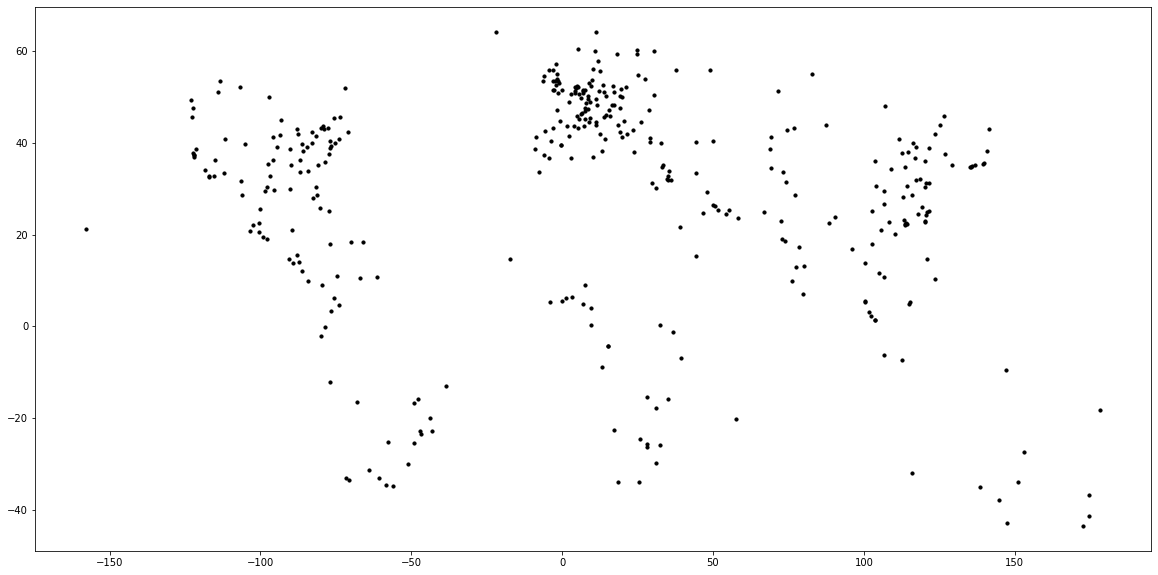

In [10]:
fig = plt.figure(figsize=(20,10))
plt.scatter(city_df.longitude, city_df.latitude, c='k',s=10);

### Rankings
You may have noticed that the actual rankings from the original list are not in this dataset. I will quickly rectify this.

Since all of the cities are still in the order they came in, it can be done using the first and last city of each rank.

Here are the buckets:

|From|To|Rank|
|---|---|---|
|London|New York|Alpha++|
|Hong Kong|Tokyo|Alpha+|
|Sydney|Brussels|Alpha|
|Warsaw|Bangalore|Alpha-|
|Washington DC|Auckland|Beta+|
|Ho Chi Minh City|Panama City|Beta|
|Wuhan|Austin|Beta-|
|San Jose|Baltimore|Gamma+|
|Durban|Wellington|Gamma|
|Port Louis|Edmonton|Gamma-|
|Birmingham|Porto Alegre|High Sufficiency|
|Tallinn|Suva|Sufficiency|

In [11]:
rank_table = r'''|London|New York|Alpha++|
|Hong Kong|Tokyo|Alpha+|
|Sydney|Brussels|Alpha|
|Warsaw|Bangalore|Alpha-|
|Washington DC|Auckland|Beta+|
|Ho Chi Minh City|Panama City|Beta|
|Wuhan|Austin|Beta-|
|San Jose|Baltimore|Gamma+|
|Durban|Wellington|Gamma|
|Port Louis|Edmonton|Gamma-|
|Birmingham|Porto Alegre|High Sufficiency|
|Tallinn|Suva|Sufficiency|'''
# yes this is the markdown for the buckets above...
# did you think I would write it twice?

In [12]:
# processing my markdown table into a list
rank_list = rank_table.split('|')

i = 0
while True:
    try:
        if rank_list[i] == ''\
        or rank_list[i] == '\n':
            del rank_list[i]
        else:
            i+=1
    except IndexError:
        break

In [13]:
city_df['ranking'] = ''

for i in range(len(rank_list)):
    # find where a ranking (every 3rd item) is in the list
    if (i + 1) % 3 == 0:
        # start of this ranking's bucket is 2 back
        start = city_df[(city_df.city_name == rank_list[i-2])]\
        .sort_values(by='city_name')\
        .index[0] # and the first (usually only) result of the mask
        
        if rank_list[i-2] == 'San Jose':
            start = city_df[(city_df.city_name == rank_list[i-2])]\
            .sort_values(by='city_name')\
            .index[1] # for San Jose it's actually the second result
        
        # end of the bucket is 1 back
        stop = city_df[(city_df.city_name == rank_list[i-1])]\
        .sort_values(by='city_name')\
        .index[0]
        
        # assign the ranking
        city_df.loc[start:stop+1,'ranking'] = rank_list[i]

In [25]:
# saving work
city_df.to_csv('./data/GaWCcities_with_rankings.csv',index=False)
city_df.head()

,city_name,latitude,longitude,ranking
0,London,51.507222,-0.1275,Alpha++
1,New York,40.712778,-74.006111,Alpha++
2,Hong Kong,22.3,114.2,Alpha+
3,Singapore,1.283333,103.833333,Alpha+
4,Shanghai,31.228611,121.474722,Alpha+


## Visualization

Now that I have my dataset of city names, lat/lon coordinates and rankings, I can start working on the visualization. Let me explain what my goal is a little more first, so that the steps make more sense.

Everywhere where there are many cities close together, I want to create a "landmass" which is a polygon drawn around the cluster of cities and intersected with the shape of the actual landmass(es) they are one. I will then divide this landmass using the voronoi diagram of the cities that are on it. The end result is that clusters are split into little regions representing each city's sphere of influence. Note that this is not meant to represent the actual geographic extent of a city's influence; it just looks cool.

The cities that are not clustered each have a circle drawn around them, which is then also intersected with the shape of the coastline.

All of these polygons will then be colored according to the city's rank.

### Clustering
I chose DBSCAN as the clustering algorithm because it is conducive to the results I want. DBSCAN makes clusters of non-circular shape and leaves outlier points out of it.

In [14]:
# load dataframe with all prework complete
city_df = pd.read_csv('./data/GaWCcities_with_rankings.csv')
# adding a city_id column will be relevant later
city_df['city_id'] = np.arange(city_df.shape[0])

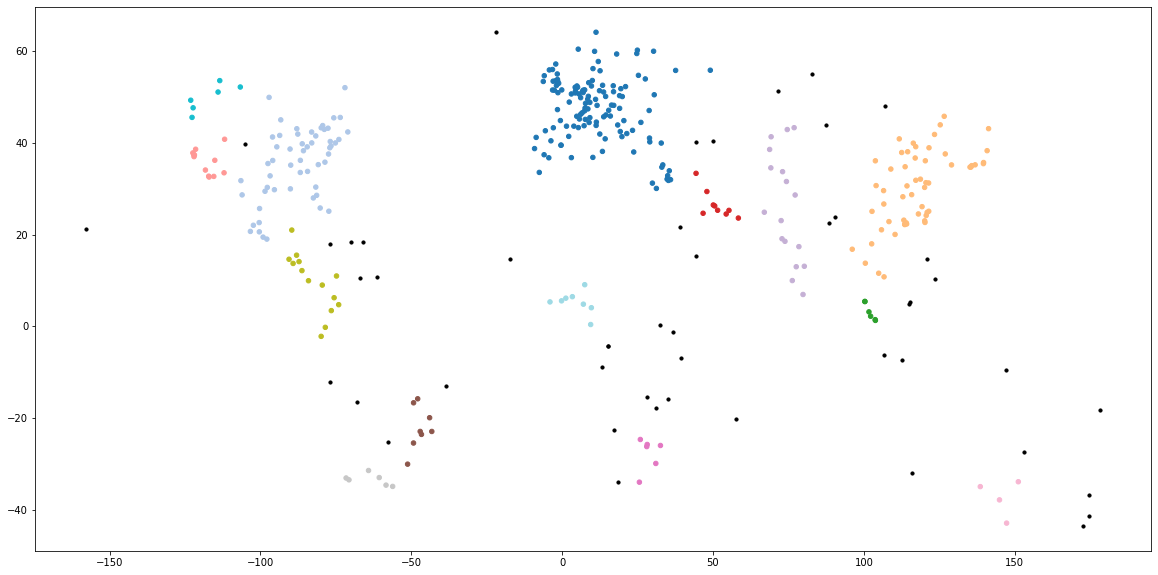

In [15]:
# hyperparameters
eps = 777 / 6371  # 777km (in radians)
samples = 4

# model definition and fit
model = DBSCAN(eps=eps,
               metric='haversine',
               algorithm='ball_tree',
               min_samples=samples)

X = city_df[['latitude','longitude']]
model.fit(np.radians(X))

city_df['labels'] = model.labels_
   
# scatterplot
fig = plt.figure(figsize=(20,10))
clustered = city_df[(city_df.labels != -1)]
unclustered = city_df[(city_df.labels == -1)]
plt.scatter(clustered.longitude, clustered.latitude, c=clustered.labels, cmap='tab20',s=20)
plt.scatter(unclustered.longitude, unclustered.latitude, c='k', cmap='tab20',s=10);

I manually played around with epsilon (the minimum distance for points to be in the same cluster) for a while in order to get the result that looked the best. I chose 777 because it was the nicest number within the fairly tight range that allowed for the following interesting properties:
- Cascadia / W. Canada gets a cluster
- North America doesn't absorb the West Coast and Central America
- South America has two clusters
- Africa and Australia have nice-looking clusters
- The Persian Gulf is separate from Europe and India / Central Asia
- SE Asia is separate from East Asia

It was a bit of a compromise however, because I sacrificed these other possible properties by choosing this range:
- Levant separate from Europe
- Central Asia separate from India

It was my subjective opinion that this set of tradeoffs most accurately balanced the massiveness of megaregions like North America, Europe, and East Asia with the underlying diversity of more specific regional sets of cities, like the Southern Cone vs. Brazil. Also I found it most aesthetically pleasing.

I also chose the min_samples hyperparameter as 4 specifically because of Australia.

### Cluster Boundaries
With my clusters set up, now it's time to make some landmasses. I tried many different methods of accomplishing this, but landed on first buffering the points and then creating a *concave* hull from the buffered points as the best one for my purposes. This is because many of the clusters are long and thin, so they would need to be buffered more in one direction than the other to make sense as landmasses. If I just buffer a convex or concave hull, the result is not as good.

Buffering is a process where you essentially draw a circle of points around each point.

In [16]:
# scale and resolution for buffering
cb_scale = 1/3
ib_scale = 1/6
b_res = 4

# make city_df into a geodataframe
city_gdf = gpd.GeoDataFrame(city_df)

# with point geometries derived from lat/lon
points = []
for lat,lon in zip(city_gdf.longitude, city_gdf.latitude,):
    points.append(geometry.Point((lat,lon)))

city_gdf['geometry'] = points

# make the landmasses and islands
landmass_list = []
for label in set(city_gdf.labels):
    
    region = city_gdf[city_gdf.labels==label].copy()
    
    # unclustered points become "islands"
    if label == -1:

        island_buffers = gpd.GeoDataFrame(
            data = region.buffer(np.degrees(eps * ib_scale)),
            columns = ['geometry']
        )

    # clustered points become "landmasses"
    else:

        region_buffer = gpd.GeoDataFrame(
            data = region.buffer(np.degrees(eps * cb_scale), b_res),
            columns = ['geometry']
        ).dissolve().iloc[0,0] # I actually just want the polygon

        # get the points for the concave hull
        if region_buffer.geom_type == 'MultiPolygon':
            points = []
            polys = region_buffer.geoms
            for poly in polys:
                points += poly.exterior.coords
        else:
            points = list(region_buffer.exterior.coords)

        # make the concave hull
        concave = alphashape.alphashape(points,0.215)

        landmass_list.append(concave)

landmass_df = gpd.GeoDataFrame(
    data = np.array(landmass_list),
    columns = ['geometry']
)

landmass_df['temp_cluster_id'] = np.arange(landmass_df.shape[0])

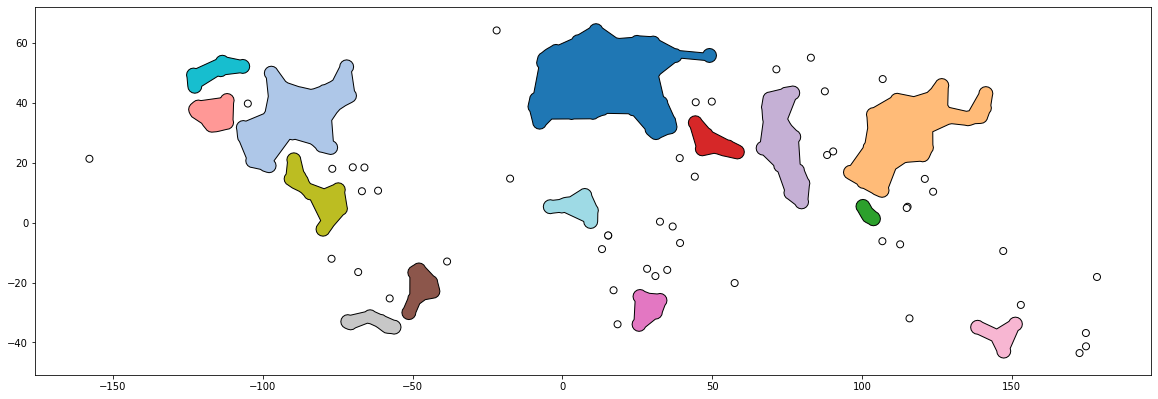

In [17]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()
landmass_df.plot(landmass_df['temp_cluster_id'],ax=ax,cmap='tab20',edgecolor='k')
island_buffers.plot(ax=ax,edgecolor='k', color = 'w');

### Voronoi
With my big cluster areas defined, I can now create the voronoi diagrams for each of them using the cities contained in them.

When a voronoi diagram is created, some of the vertices of the regions (which I want to use as polygons) are "outside the diagram" (theoretically at or near infinity). In the scipy library, this is represented as an index of **-1** for the vertices. Unfortunately, when making polygons, that index is interpreted as the last vertex in the array of vertices, which is incorrect and leads to severely distorted and overlapping polygons. To get arround this, a complicated process of finding the two points separated by some ridge that goes towards an infinite vertex and a vector going towards the midpoint between them is needed. The result of this is a point *far enough* outside of the diagram that it will also be outside of my cluster boundaries, achieving the desired effect.

Fortunately, this proccess was very effectively implemented in this stack overflow answer https://stackoverflow.com/a/52727406

I have copied it below and use that stack overflow user's function un-altered.

In [18]:
def voronoi_polygons(voronoi, diameter):
    """Generate shapely.geometry.Polygon objects corresponding to the
    regions of a scipy.spatial.Voronoi object, in the order of the
    input points. The polygons for the infinite regions are large
    enough that all points within a distance 'diameter' of a Voronoi
    vertex are contained in one of the infinite polygons.

    """
    centroid = voronoi.points.mean(axis=0)

    # Mapping from (input point index, Voronoi point index) to list of
    # unit vectors in the directions of the infinite ridges starting
    # at the Voronoi point and neighbouring the input point.
    ridge_direction = defaultdict(list)
    for (p, q), rv in zip(voronoi.ridge_points, voronoi.ridge_vertices):
        u, v = sorted(rv)
        if u == -1:
            # Infinite ridge starting at ridge point with index v,
            # equidistant from input points with indexes p and q.
            t = voronoi.points[q] - voronoi.points[p] # tangent
            n = np.array([-t[1], t[0]]) / np.linalg.norm(t) # normal
            midpoint = voronoi.points[[p, q]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - centroid, n)) * n
            ridge_direction[p, v].append(direction)
            ridge_direction[q, v].append(direction)

    for i, r in enumerate(voronoi.point_region):
        region = voronoi.regions[r]
        if -1 not in region:
            # Finite region.
            yield Polygon(voronoi.vertices[region])
            continue
        # Infinite region.
        inf = region.index(-1)              # Index of vertex at infinity.
        j = region[(inf - 1) % len(region)] # Index of previous vertex.
        k = region[(inf + 1) % len(region)] # Index of next vertex.
        if j == k:
            # Region has one Voronoi vertex with two ridges.
            dir_j, dir_k = ridge_direction[i, j]
        else:
            # Region has two Voronoi vertices, each with one ridge.
            dir_j, = ridge_direction[i, j]
            dir_k, = ridge_direction[i, k]

        # Length of ridges needed for the extra edge to lie at least
        # 'diameter' away from all Voronoi vertices.
        length = 2 * diameter / np.linalg.norm(dir_j + dir_k)

        # Polygon consists of finite part plus an extra edge.
        finite_part = voronoi.vertices[region[inf + 1:] + region[:inf]]
        extra_edge = [voronoi.vertices[j] + dir_j * length,
                      voronoi.vertices[k] + dir_k * length]
        yield Polygon(np.concatenate((finite_part, extra_edge)))

In [19]:
vl_list = []
for label in set(city_gdf.labels):
    # ignore islands label
    if label == -1:
        continue

    # get the voronoi diagram, note latitude and longitude are
    # intentionally reversed because voronoi is agnostic of CRS
    vor = Voronoi(
        city_gdf.loc[
            (city_gdf.labels==label),
            ['longitude','latitude']
        ])

    # voronoi_polygons makes a generator, but I only need a list
    polygons = [p for p in voronoi_polygons(vor, vor.points.ptp(axis=0))]

    polygons_gdf = gpd.GeoDataFrame(polygons, columns = ['geometry'])

    # overlay the polygons on the appropriate cluster boundaries
    voronoi_landmass = gpd.overlay(
        polygons_gdf,
        landmass_df[(landmass_df.temp_cluster_id==label)],
        how='intersection'
    )

    # rejoin at this specific stage is important, because if after
    # coast overlay it breaks referential integrity
    voronoi_landmass = voronoi_landmass.sjoin(city_gdf,how='left')
    # make sure each city has only one geometry!
    voronoi_landmass = voronoi_landmass.dissolve(by='index_right')

    vl_list.append(voronoi_landmass)

vldf = gpd.GeoDataFrame(pd.concat(vl_list))

In [20]:
# rejoin islands with their city data too
island_buffers = island_buffers.sjoin(city_gdf,how='left')
island_buffers = island_buffers.dissolve(by='index_right')

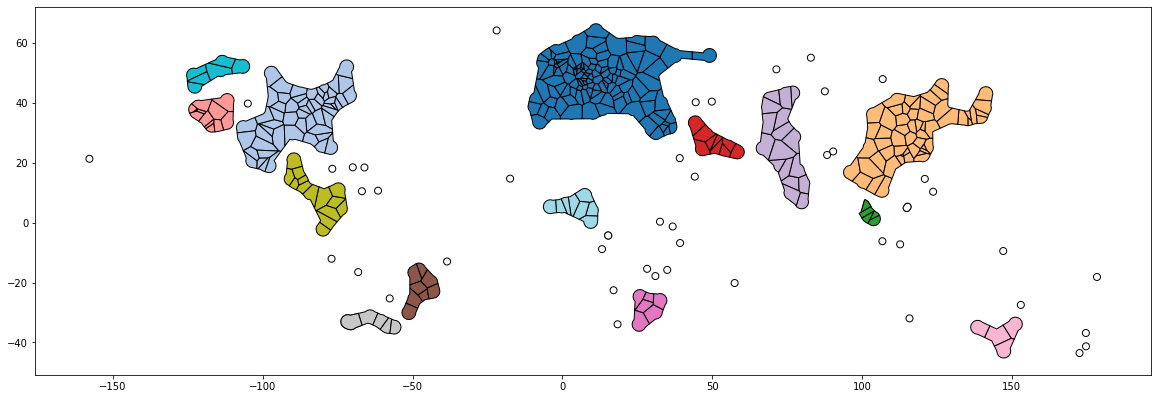

In [21]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()
vldf.plot(vldf['temp_cluster_id'],ax=ax,cmap='tab20',edgecolor='k')
island_buffers.plot(ax=ax,edgecolor='k', color = 'w');

### Coastline Overlay
With rough geometries created, now it's time to overlay this onto the actual coastline. I got coastline information from the GSHHS shapefile, which can be found online here: https://www.ngdc.noaa.gov/mgg/shorelines/gshhs.html

I decided to use the lowest resolution, as it was better suited for the style of my visualization.

In [22]:
coast = gpd.read_file('./data/world/GSHHS_shp/c/GSHHS_c_L1.shp')

# overlay with coast
vldf.set_crs(4326, inplace=True)
island_buffers.set_crs(4326, inplace=True)

vldf = gpd.overlay(vldf,coast,how='intersection')
vldf = vldf.dissolve(by='city_id')

island_boundaries = gpd.overlay(island_buffers,coast,how='intersection')
island_boundaries = island_boundaries.dissolve(by='city_id')

In [23]:
# stick islands and land back together
geoms_final = gpd.GeoDataFrame(pd.concat([vldf, island_boundaries]))
geoms_final.reset_index(inplace=True)
cols = list(city_gdf.columns)
cities_vlm = geoms_final[cols]

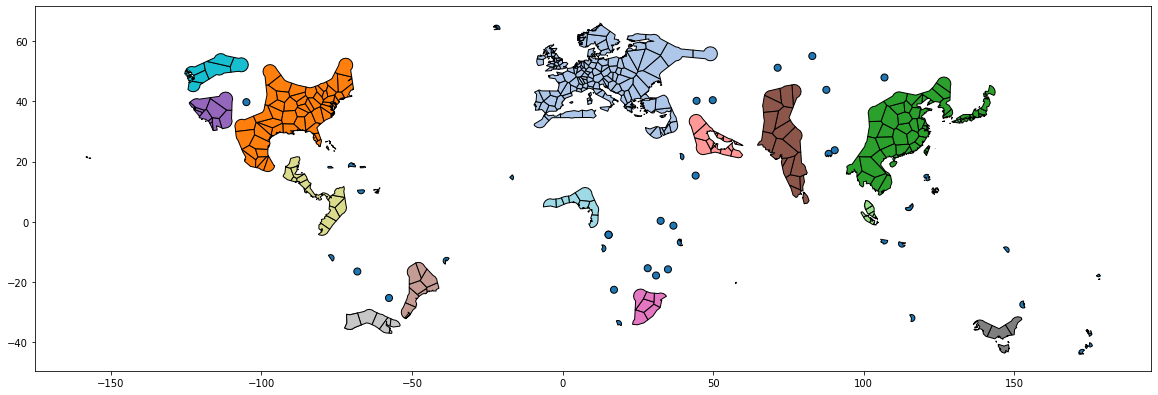

In [24]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()
cities_vlm.plot(cities_vlm.labels,edgecolor='k', cmap='tab20', ax=ax);

### Incorporating Rankings
I'm already very happy with the cluster-colored visualization above, but the original point was still to show the actual rankings. All that's needed to make this happen is an order for the ranks that are already in the dataframe

In [25]:
ordered_ranks = ['Sufficiency',
                 'High Sufficiency',
                 'Gamma-',
                 'Gamma',
                 'Gamma+',
                 'Beta-',
                 'Beta',
                 'Beta+',
                 'Alpha-',
                 'Alpha',
                 'Alpha+',
                 'Alpha++']

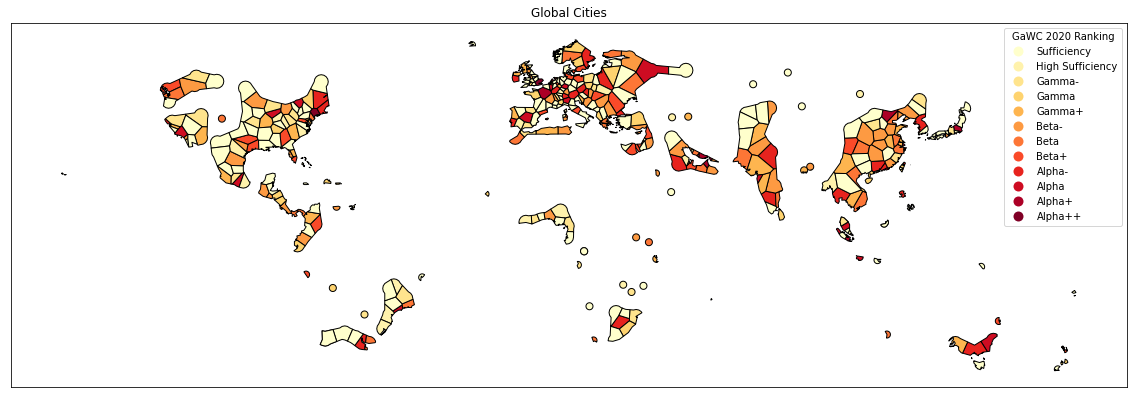

In [26]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()
cities_vlm.plot(cities_vlm.ranking,
                edgecolor='k',
                cmap='YlOrRd',
                ax=ax,
                legend=True,
                categories=ordered_ranks,
                legend_kwds={'title':'GaWC 2020 Ranking'}
               )
ax.yaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_title('Global Cities');

## Conclusion

There might be easier ways to visualize this data, but this unique idea of mine was a good chance to implement something new, since I was already comfortable making more standard visualizations that take only a few lines of code in matplotlib.

There might also be easier datasets to visualize, but the lack of a nice, high-quality, pre-formatted dataset here gave me a fun additional challenge and let me showcase abilities that would be very useful in a production setting but are sometimes hard to demonstrate in a project.

I hope you like the visualization itself, and that this project has demonstrated at least some creativity, problem solving ability, and technical skill on my part. Thank you for your time in taking a look at this.

In [ ]:
# bonus: this version of the visualization makes a nice desktop
# especially on a black background

fig = plt.figure(figsize=(26,13))
ax = plt.axes()
coast.plot(edgecolor='k',color='w',ax=ax, alpha = 0.25)
cities_vlm.plot(cities_vlm.ranking,
                edgecolor='k',
                cmap='Reds_r',
                ax=ax,
                # legend=True,
                # categories=ordered_ranks,
                # legend_kwds={'title':'GaWC 2020 Ranking'}
               )
ax.yaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.axis('off');

plt.savefig('./desktop_background.png')